# Introduction
A natural question arises from the rapid evolution of pretrained language models: for a downstream task like text classification, is it better to use a monolingual model trained on a single language, or a multilingual model exposed to dozens of languages?
This notebook investigates that question.

# Table of Contents
0. Package Installation and Module Imports
1. Data Preparation and Wrangling  
   1.1 Spanish Dataset  
   1.2 Chinese Dataset  
   1.3 English Dataset  
   1.4 Parallel Dataset Corpus
2. Utility Functions
3. Zero-Shot Sentiment Prediction  
   3.0 Monolingual Models  
       3.0.1 Chinese Only  
       3.0.2 English Only  
       3.0.3 Spanish Only  
   3.1 Multilingual Models  
       3.1.1 mT5-base  
       3.1.2 XLM-RoBERTa  
       3.1.3 mBERT (finetuned)  
   3.2 Large Language Models  
       3.2.1 Gemini 2.0 Flash  
       3.2.2 Llama 3.1 Lite  
       3.2.3 Qwen 2  
       3.2.4 Mistral

# 0. package install and Module Import

In [1]:
"""
Installing required packages
"""
%pip install liqfit
%pip install hf_xet
%pip install -U bitsandbytes
%pip uninstall transformers
%pip install git+https://github.com/huggingface/transformers
%pip install accelerate
%pip install prettytable
%pip install pandas pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [4]:
"""
Importing required libraries
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import google.generativeai as genai
import random
import time
from google.colab import drive
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from liqfit.pipeline import ZeroShotClassificationPipeline
from liqfit.models import T5ForZeroShotClassification
from transformers import T5Tokenizer, AutoTokenizer, Llama4ForConditionalGeneration, AutoModelForCausalLM, logging as hf_logging, pipeline, AutoTokenizer, AutoModelForSequenceClassification, Qwen2_5OmniProcessor, Qwen2_5OmniThinkerForConditionalGeneration,AutoModel,T5EncoderModel
import torch
from sentence_transformers import SentenceTransformer
from tabulate import tabulate
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
hf_logging.set_verbosity_error()
from datasets import load_dataset
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import umap
import matplotlib.pyplot as plt
import math
from IPython.display import display
from sklearn.metrics import top_k_accuracy_score
## For random Seed
myStudentNumber = 230164781

In [3]:
"""
mounting Google Drive to access the dataset
"""

drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Prepration and Wrangling

## 1.1. Spanish Dataset

In [5]:
"""
Source:
https://portal.odesia.uned.es/en/dataset/finances-2023
"""

dfSpanish = pd.read_csv("/content/drive/MyDrive/Dissertation_NclxOw/Data/Archive/master_dataset_spanish.csv")

In [6]:

dfSpanish = dfSpanish.copy()

dfSpanish.drop(
    ["companies_sentiment", "consumers_sentiment", "target", "id"],
    axis=1,
    inplace=True
)
dfSpanish.rename(
    columns={'target_sentiment': 'label', 'text': 'sentence'},
    inplace=True
)
dfSpanish.loc[:, 'label'] = dfSpanish['label'].replace('postive', 'positive')


In [7]:
print(dfSpanish['label'].value_counts())
dfSpanish = (
    dfSpanish
    .groupby('label', group_keys=False)
    .sample(n=50, random_state=myStudentNumber)
    .sample(frac=1, random_state=myStudentNumber)
    .reset_index(drop=True)
)
print(dfSpanish['label'].value_counts())

label
positive    371
negative    305
neutral      60
Name: count, dtype: int64
label
positive    50
negative    50
neutral     50
Name: count, dtype: int64


In [8]:
"""
Shuffling the dataset
"""
dfSpanish = dfSpanish.sample(frac=1, random_state=myStudentNumber).reset_index(drop=True)

dfSpanish.head()

,sentence,label
0,Los coches eléctricos cortocircuitarán a los c...,negative
1,Hacienda y las CCAA analizan el jueves la refo...,neutral
2,"El coste de la hora trabajada sube un 2,9% en ...",positive
3,Firmado el acuerdo para subir el salario mínim...,positive
4,El Tribunal Supremo convierte en indefinidos a...,neutral


In [9]:
dfSpanish.to_csv("/content/drive/MyDrive/Dissertation_NclxOw/Data/the_spanish_financial_dataset.csv", index=False)

## 1.2. Chinese Dataset

In [10]:
"""
Dataset source:
https://huggingface.co/datasets/hw2942/financial-news-sentiment
"""

dfChinese = pd.read_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/Archive/master_dataset_chinese.csv')

dfChinese.rename(columns={'labels': 'label', 'Title': 'sentence'}, inplace=True)

dfChinese['label'] = dfChinese['label'].replace({
    2: 'positive',
    0: 'negative',
    1: 'neutral'
})

In [11]:
print(dfChinese['label'].value_counts())
dfChinese = (
    dfChinese
    .groupby('label', group_keys=False)
    .sample(n=50, random_state=myStudentNumber)
    .sample(frac=1, random_state=myStudentNumber)
    .reset_index(drop=True)
)
print(dfChinese['label'].value_counts())

label
neutral     1252
positive     555
negative     522
Name: count, dtype: int64
label
positive    50
negative    50
neutral     50
Name: count, dtype: int64


In [12]:
dfChinese.head()

,sentence,label
0,机构：锂电池回收政策落地 百亿回收市场有望打开,positive
1,神雾环保2017年净利润6.05亿元 同比下滑14.3%,negative
2,2017年临汾市战略性新兴产业投资强势增长,positive
3,2018年苹果将推出新款iPhone X、大号版、廉价版三款设备,neutral
4,中航国际控股：天马年度净利增41.82%至8.07亿元,positive


In [13]:
dfChinese.to_csv("/content/drive/MyDrive/Dissertation_NclxOw/Data/the_chinese_financial_dataset.csv", index=False)

## 1.3. English Dataset

In [14]:
"""
Dataset source:
financial phase-bank dataset
https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

"""


dfEnglish = pd.read_csv('/content/drive/MyDrive/Dissertation_NclxOw/Data/Archive/master_dataset_english.csv', encoding='latin-1')

In [15]:
dfEnglish.columns = ['label', 'sentence']

In [16]:
print(dfEnglish['label'].value_counts())
dfEnglish = (
    dfEnglish
    .groupby('label', group_keys=False)
    .sample(n=50, random_state=myStudentNumber)
    .sample(frac=1, random_state=myStudentNumber)
    .reset_index(drop=True)
)
print(dfEnglish['label'].value_counts())

label
neutral     2878
positive    1363
negative     604
Name: count, dtype: int64
label
positive    50
negative    50
neutral     50
Name: count, dtype: int64


In [17]:
dfEnglish.head()

,label,sentence
0,positive,M-real 's sales are expected to have increased...
1,negative,"Commission income decreased to EUR 3.8 mn , co..."
2,positive,"AUSTIN , Texas , Sept. 6 -- Texas Department O..."
3,neutral,`` Nokia is just interested in bring Nokia to ...
4,positive,The company said that it will supply the WCDMA...


In [18]:
dfEnglish.to_csv("/content/drive/MyDrive/Dissertation_NclxOw/Data/the_english_financial_dataset.csv", index=False)

# 2. Utility functions

In [ ]:
!huggingface-cli login


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `llama4` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/hug

In [19]:
"""
Function for Evaluation.
"""
def confusionMatrix(df, labels):
    cm = confusion_matrix(df["label"], df["prediction"])
    cmDF = pd.DataFrame(
        cm,
        index=[f"True {l}" for l in labels],
        columns=[f"Pred {l}" for l in labels]
    )
    return cmDF

def evaluate(df):
    labels = ['negative','neutral','positive']
    cm = confusion_matrix(df.label, df.prediction)
    cmDF = pd.DataFrame(cm, index=labels, columns=labels)

    metrics = {
        "accuracy": accuracy_score(df.label, df.prediction),
        "precision": precision_score(df.label, df.prediction, average='macro'),
        "recall": recall_score(df.label, df.prediction, average='macro'),
        "f1_score": f1_score(df.label, df.prediction, average='macro'),
    }
    metricsDf = pd.DataFrame.from_dict(metrics, orient='index', columns=['value'])
    return cmDF, metricsDf


In [20]:


def plot_confusion_matrix(cm_df, figsize=(6,5), cmap=None, annot=True):
    """
    Renders and saves a heatmap of your confusion matrix.
    """
    cm = cm_df.values
    labels = cm_df.index.tolist()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # Tick labels
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel='True label',
        xlabel='Predicted label',
        title='Confusion Matrix'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotate each cell with its value
    if annot:
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center")

    fig.tight_layout()
    return fig


def plot_metrics_bar(metrics_df, figsize=(6,4)):
    """
    Renders and saves a bar chart of your evaluation metrics.
    """
    names = metrics_df.index.tolist()
    values = metrics_df['value'].tolist()

    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(names, values)
    ax.set_ylim(0, 1)  # since these are proportions
    ax.set_ylabel('Score')
    ax.set_title('Evaluation Metrics')

    # Annotate bars with their numeric value
    for bar, v in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.02, f'{v:.2f}',
                ha='center', va='bottom')

    fig.tight_layout()
    return fig


In [ ]:
"""
Google Gemini API Key
"""
apiKey = ""

geminiFlash = genai.GenerativeModel('gemini-2.0-flash')
genai.configure(api_key=apiKey)

In [22]:
"""
Initilising the models

https://huggingface.co/joeddav/xlm-roberta-large-xnli

https://huggingface.co/knowledgator/comprehend_it-multilingual-t5-base

https://huggingface.co/tabularisai/multilingual-sentiment-analysis

https://huggingface.co/Joseph717171/Llama-3.1-SuperNova-8B-Lite_TIES_with_Base

https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3

"""

xlmRoberta = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

mT5Base = ZeroShotClassificationPipeline(model=T5ForZeroShotClassification.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base'), tokenizer=T5Tokenizer.from_pretrained('knowledgator/comprehend_it-multilingual-t5-base'), hypothesis_template = '{}', encoder_decoder = True)


# mbertFinetunedTokenizer = AutoTokenizer.from_pretrained("tabularisai/multilingual-sentiment-analysis")
# mbertFinetuned = AutoModelForSequenceClassification.from_pretrained("tabularisai/multilingual-sentiment-analysis")


# geminiFlash = genai.GenerativeModel('gemini-2.0-flash')
# genai.configure(api_key=apiKey)


# llama = pipeline("text-generation", model= AutoModelForCausalLM.from_pretrained(
#     "Joseph717171/Llama-3.1-SuperNova-8B-Lite_TIES_with_Base",
#     device_map="auto",
#     load_in_8bit=True,
#     offload_folder="offload",
#     offload_state_dict=True,
#     offload_buffers=True
# )
# , tokenizer=AutoTokenizer.from_pretrained("Joseph717171/Llama-3.1-SuperNova-8B-Lite_TIES_with_Base", use_fast=True))





# Qwen2Processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-7B")
# Qwen2 = Qwen2_5OmniThinkerForConditionalGeneration.from_pretrained("https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3", device_map="auto",torch_dtype="auto")




# mistral = pipeline("text-generation", model=AutoModelForCausalLM.from_pretrained(
#     "mistralai/Mistral-7B-Instruct-v0.3",
#     device_map="auto",
#     load_in_8bit=True,
#     offload_folder="offload",
#     offload_state_dict=True,
#     offload_buffers=True
# )
# , tokenizer=AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3", use_fast=True))


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

In [26]:
"""
Mono-Lingual Models
"""


chineseMonoModel= pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone-chinese",
    tokenizer="yiyanghkust/finbert-tone-chinese",
    return_all_scores=False
)

englishMonoModel = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=False
)
spanishMonoModel = pipeline(
    "sentiment-analysis",
    model="pysentimiento/robertuito-sentiment-analysis",
    tokenizer="pysentimiento/robertuito-sentiment-analysis",
    return_all_scores=False
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [23]:
def classifyText(text,model=None):
  msg = [
        {
            "role": "system",
            "content": "just output one word: positive, negative or neutral in lowercase in english no explaination needed"
        },
        {
            "role": "user",
            "content": f"Analyse the sentiment of the sentence: \"{text}\""
        }
    ]


#   # Chinese Mono Model
  if model==chineseMonoModel:
    _label_map = {
    "Neutral": "neutral",
    "Positive": "positive",
    "Negative": "negative"
}
    out = chineseMonoModel(text)[0]
    return _label_map[out["label"]]
  # English Mono Model
  elif model==englishMonoModel:
    out = englishMonoModel(text)[0]
    return out["label"]

#   elif model==spanishMonoModel:
#     _label_map = {
#         "NEG": "negative",
#         "NEU": "neutral",
#         "POS": "positive",
# }
#     out = spanishMonoModel(text)[0]
#     return _label_map[out["label"]]

#   # Gemini Flash
#   elif model==geminiFlash:
#     prompt = f"Analyse the sentiment of the {text}. just output one word. It should be either positve, negative or neutral in smallcase"
#     response = geminiFlash.generate_content(prompt)
#     modified_col2 = response.text.strip()
#     time.sleep(random.uniform(2, 5))
#     return modified_col2

#   # Llama
#   elif model==llama:

#     prediction = llama(msg)
#     content= prediction[0]['generated_text'][-1]['content']
#     return content

#   # Qwen 2
#   elif model==Qwen2:
#     msg = f"Analyse the sentiment of the given sentence '{text}'. just output one word. It should be either positive or negative in lowercase in english, i don't need any explanation, just one word"
#     inputs = Qwen2Processor(text=msg, return_tensors="pt").to(model.device)
#     out_ids = model.generate(**inputs, max_new_tokens=8)
#     word = Qwen2Processor.tokenizer.decode(out_ids[0], skip_special_tokens=False).strip()
#     last_word = word.rsplit('.', 1)[-1].strip()
#     content= last_word.split('\n',1)[0]
#     return content

  #MT5-5 base and xlmRoberta
  elif model==mT5Base or model==xlmRoberta:
    labels = ['negative', 'positive', 'neutral' ]
    result = model(text, labels)
    maxScore = float('-inf')
    maxLabel = None
    for label, score in zip(result['labels'], result['scores']):
        if score > maxScore:
            maxScore = score
            maxLabel = label
    return maxLabel


  # #mBERT Finetuned
  # elif model == mbertFinetuned:
  #   inputs = mbertFinetunedTokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
  #   with torch.no_grad():
  #       outputs = mbertFinetuned(**inputs)
  #   probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
  #   neg = probs[:, 0] + probs[:, 1]
  #   neu = probs[:, 2]
  #   pos = probs[:, 3] + probs[:, 4]
  #   collapsed = torch.stack([neg, neu, pos], dim=1)
  #   preds = torch.argmax(collapsed, dim=1).tolist()
  #   sentiment_map = {
  #       0: "negative",
  #       1: "neutral",
  #       2: "positive"
  #   }
  #   a =  [sentiment_map[p] for p in preds]
  #   return a[0]


  # # Mistral
  # elif model==mistral:
  #   prediction = mistral(msg)
  #   content= prediction[0]['generated_text'][1]['content']
  #   sentiment = prediction[0]['generated_text'][-1]['content'].strip()
  #   return sentiment



In [24]:
def sentimentAnalysis(df,model=None):
    predictions = []
    for index, row in df.iterrows():
        text = row['sentence']
        prediction = classifyText(text,model)
        predictions.append(prediction)
    return predictions


# 3. Zero Shot Sentiment prediction

## 3.0. Monolingual models

### 3.0.1 Chinese Only

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


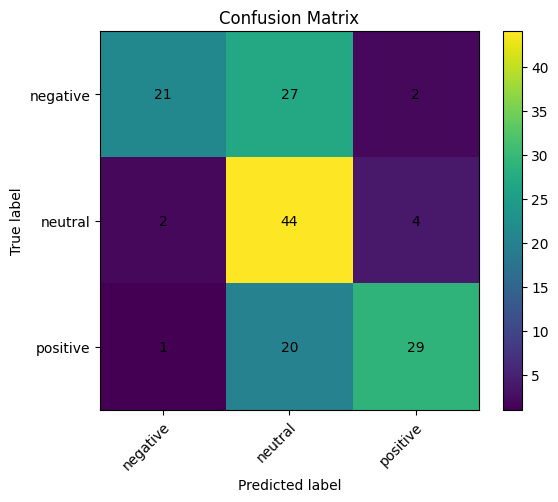

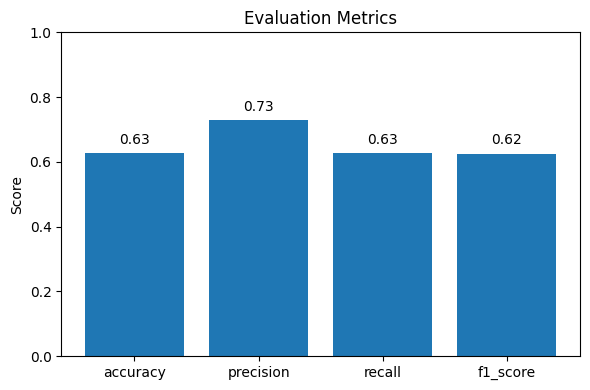

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,chineseMonoModel)
evaluate(dfChinese)
# 1) Compute your results
cm_df, metrics_df = evaluate(dfChinese)

# 2) Make the two figures
cm_fig = plot_confusion_matrix(cm_df)
met_fig = plot_metrics_bar(metrics_df)

# 3) Save them as high‑res PNGs for your poster
cm_fig.savefig('confusion_matrix_mono_chinese.png', dpi=300)
met_fig.savefig('metrics_bar_chart_mono_chinese.png', dpi=300)



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


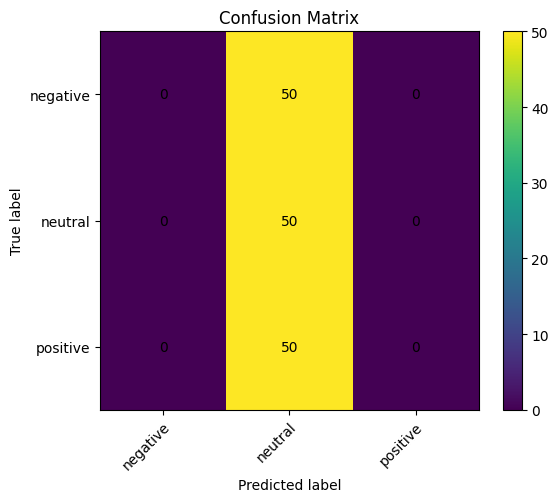

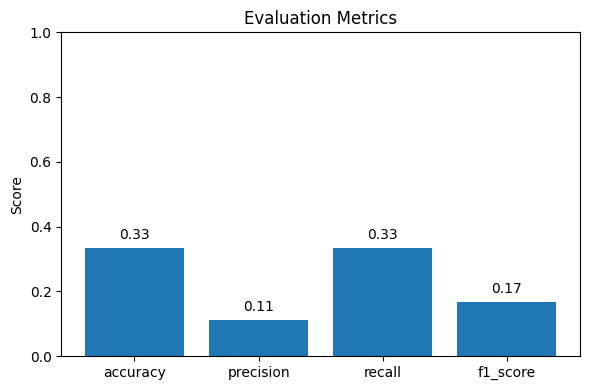

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,chineseMonoModel)

cm_df, metrics_df = evaluate(dfEnglish)

# 2) Make the two figures
cm_fig = plot_confusion_matrix(cm_df)
met_fig = plot_metrics_bar(metrics_df)

# 3) Save them as high‑res PNGs for your poster
cm_fig.savefig('confusion_matrix_mono_chinese.png', dpi=300)
met_fig.savefig('metrics_bar_chart_mono_chinese.png', dpi=300)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,chineseMonoModel)
evaluate(dfSpanish)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(          negative  neutral  positive
 negative         0       50         0
 neutral          0       50         0
 positive         0       50         0,
               value
 accuracy   0.333333
 precision  0.111111
 recall     0.333333
 f1_score   0.166667)

### 3.0.2 English Only

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,englishMonoModel)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        19       31         0
 neutral          0       47         3
 positive         0       35        15,
               value
 accuracy   0.540000
 precision  0.749754
 recall     0.540000
 f1_score   0.522863)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,englishMonoModel)
evaluate(dfSpanish)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(          negative  neutral  positive
 negative         0       50         0
 neutral          0       50         0
 positive         0       50         0,
               value
 accuracy   0.333333
 precision  0.111111
 recall     0.333333
 f1_score   0.166667)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,englishMonoModel)
evaluate(dfChinese)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(          negative  neutral  positive
 negative         0       50         0
 neutral          0       50         0
 positive         0       50         0,
               value
 accuracy   0.333333
 precision  0.111111
 recall     0.333333
 f1_score   0.166667)

### 3.0.3. Spanish Only

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,spanishMonoModel)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        31       18         1
 neutral         11       36         3
 positive        11       32         7,
               value
 accuracy   0.493333
 precision  0.546625
 recall     0.493333
 f1_score   0.453621)

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,spanishMonoModel)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        15       35         0
 neutral          2       46         2
 positive         0       42         8,
               value
 accuracy   0.460000
 precision  0.685446
 recall     0.460000
 f1_score   0.415407)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,spanishMonoModel)
evaluate(dfChinese)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(          negative  neutral  positive
 negative         0       50         0
 neutral          0       50         0
 positive         0       50         0,
               value
 accuracy   0.333333
 precision  0.111111
 recall     0.333333
 f1_score   0.166667)

## 3.1. Multilingual models

### 3.1.1 MT5-base

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish, mT5Base)
evaluate(dfEnglish)



(          negative  neutral  positive
 negative        40        9         1
 neutral          1       42         7
 positive         5       25        20,
               value
 accuracy   0.680000
 precision  0.712161
 recall     0.680000
 f1_score   0.670940)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,mT5Base)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        33       15         2
 neutral          6       37         7
 positive         9       25        16,
               value
 accuracy   0.573333
 precision  0.602673
 recall     0.573333
 f1_score   0.560938)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,mT5Base)
evaluate(dfChinese)



(          negative  neutral  positive
 negative        31       18         1
 neutral          8       31        11
 positive         4       29        17,
               value
 accuracy   0.526667
 precision  0.568191
 recall     0.526667
 f1_score   0.527140)

### 3.1.2. xlmRoberta

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish, xlmRoberta)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        42        0         8
 neutral          1        5        44
 positive         2        3        45,
               value
 accuracy   0.613333
 precision  0.674084
 recall     0.613333
 f1_score   0.556290)

In [27]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish, xlmRoberta)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        34        1        15
 neutral          6        5        39
 positive         9        0        41,
               value
 accuracy   0.533333
 precision  0.652930
 recall     0.533333
 f1_score   0.476986)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


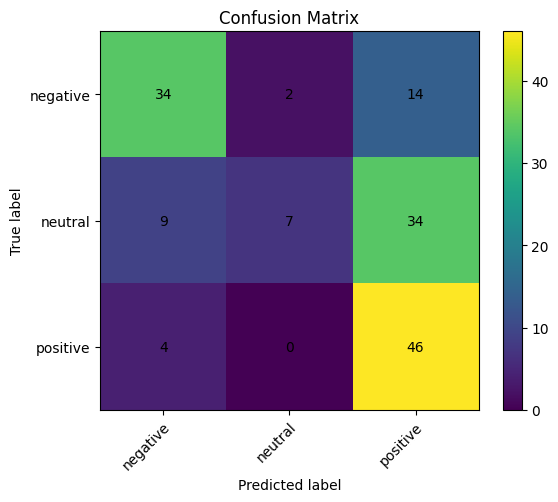

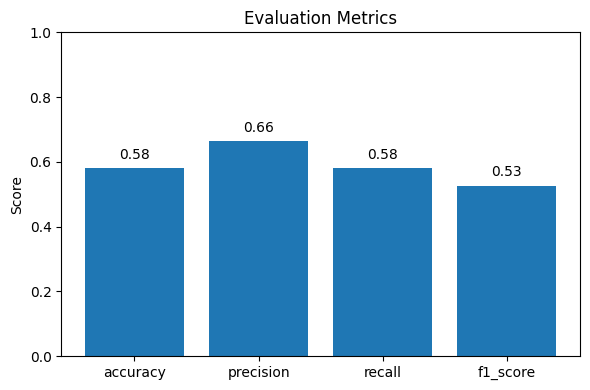

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese, xlmRoberta)



cm_df, metrics_df = evaluate(dfChinese)

# 2) Make the two figures
cm_fig = plot_confusion_matrix(cm_df)
met_fig = plot_metrics_bar(metrics_df)

# 3) Save them as high‑res PNGs for your poster
cm_fig.savefig('confusion_matrix_chi_xlm_roberta.png', dpi=300)
met_fig.savefig('metrics_bar_chart_chi_xlm_roberta.png', dpi=300)

### 3.1.3. m-BERT Finetuned

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,mbertFinetuned)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        35       10         5
 neutral          7       19        24
 positive         3       13        34,
               value
 accuracy   0.586667
 precision  0.589947
 recall     0.586667
 f1_score   0.583885)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,mbertFinetuned)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        32        9         9
 neutral         18       13        19
 positive        11       10        29,
               value
 accuracy   0.493333
 precision  0.479871
 recall     0.493333
 f1_score   0.478569)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,mbertFinetuned)
evaluate(dfChinese)

(          negative  neutral  positive
 negative        34        3        13
 neutral         21        7        22
 positive        15        3        32,
               value
 accuracy   0.486667
 precision  0.500596
 recall     0.486667
 f1_score   0.445299)

## 3.2. Large Language Models

### 3.2.1. Gemini 2.0 Flash


In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,geminiFlash)
evaluate(dfEnglish)

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1055.71ms


(          negative  neutral  positive
 negative        47        3         0
 neutral          3       39         8
 positive         0       13        37,
               value
 accuracy   0.820000
 precision  0.823771
 recall     0.820000
 f1_score   0.820602)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,geminiFlash)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        44        6         0
 neutral          6       40         4
 positive         5       23        22,
               value
 accuracy   0.706667
 precision  0.741955
 recall     0.706667
 f1_score   0.696437)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,geminiFlash)
evaluate(dfChinese)

ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1457.72ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 779.90ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 956.45ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 705.15ms


(          negative  neutral  positive
 negative        44        6         0
 neutral          6       30        14
 positive         2        6        42,
               value
 accuracy   0.773333
 precision  0.770147
 recall     0.773333
 f1_score   0.769124)

### 3.2.2. Llama 3.1 lite

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,llama)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        37       13         0
 neutral          1       47         2
 positive         0       39        11,
               value
 accuracy   0.633333
 precision  0.764862
 recall     0.633333
 f1_score   0.606996)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,llama)
dfSpanish['prediction'] = dfSpanish['prediction'].replace({
    "negativo": 'negative'
})
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        22       28         0
 neutral          5       45         0
 positive         4       42         4,
               value
 accuracy   0.473333
 precision  0.700327
 recall     0.473333
 f1_score   0.412271)

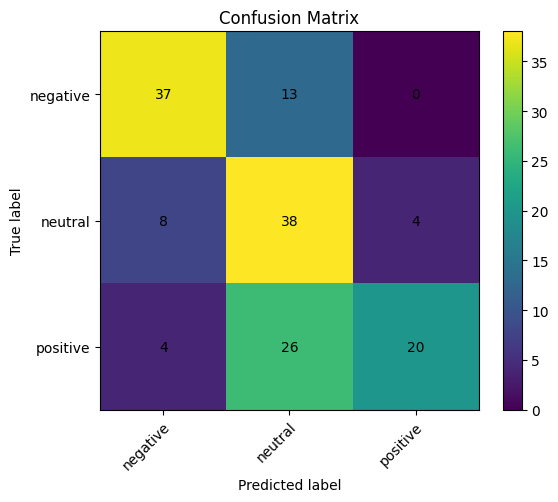

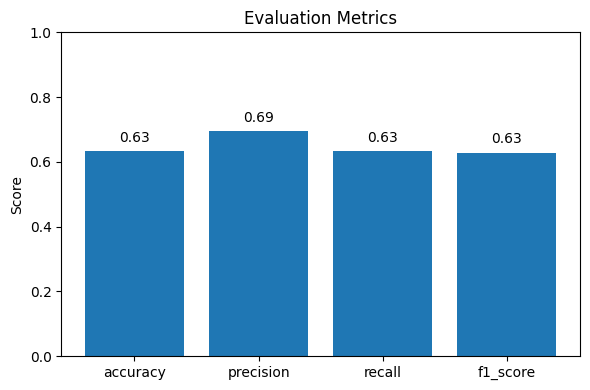

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,llama)
cm_df, metrics_df = evaluate(dfChinese)

# 2) Make the two figures
cm_fig = plot_confusion_matrix(cm_df)
met_fig = plot_metrics_bar(metrics_df)

# 3) Save them as high‑res PNGs for your poster
cm_fig.savefig('confusion_matrix_chi_llama.png', dpi=300)
met_fig.savefig('metrics_bar_chart_chi_llama.png', dpi=300)

### 3.2.3. Qwen 2

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,Qwen2)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        49        0         1
 neutral         14       12        24
 positive         3        1        46,
               value
 accuracy   0.713333
 precision  0.771129
 recall     0.713333
 f1_score   0.662037)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,Qwen2)
evaluate(dfChinese)

(          negative  neutral  positive
 negative        50        0         0
 neutral         22        3        25
 positive         8        0        42,
               value
 accuracy   0.633333
 precision  0.750622
 recall     0.633333
 f1_score   0.533462)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,Qwen2)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        49        1         0
 neutral         18       21        11
 positive        10        8        32,
               value
 accuracy   0.680000
 precision  0.693517
 recall     0.680000
 f1_score   0.661609)

### 3.2.4 Mistral

In [ ]:
dfEnglish['prediction'] = sentimentAnalysis(dfEnglish,mistral)
evaluate(dfEnglish)

(          negative  neutral  positive
 negative        44        6         0
 neutral          2       41         7
 positive         0       19        31,
               value
 accuracy   0.773333
 precision  0.797841
 recall     0.773333
 f1_score   0.776036)

In [ ]:
dfChinese['prediction'] = sentimentAnalysis(dfChinese,mistral)
evaluate(dfChinese)

(          negative  neutral  positive
 negative        37       12         1
 neutral          6       38         6
 positive         5       17        28,
               value
 accuracy   0.686667
 precision  0.712666
 recall     0.686667
 f1_score   0.687833)

In [ ]:
dfSpanish['prediction'] = sentimentAnalysis(dfSpanish,mistral)
evaluate(dfSpanish)

(          negative  neutral  positive
 negative        30       20         0
 neutral          3       46         1
 positive         4       31        15,
               value
 accuracy   0.606667
 precision  0.740846
 recall     0.606667
 f1_score   0.590017)